##Notebook 03 — Liquidity & Redemption Stress Testing (Run Risk & Settlement Lag)

This notebook extends the solvency analysis in Notebook 02 by examining
liquidity risk under redemption pressure for an RWA-backed stablecoin
system.

While solvency stress testing evaluates whether assets ultimately exceed liabilities, liquidity stress testing focuses on timing mismatches between redemption demand and asset convertibility. In Treasury-backed stablecoins, this risk is driven by redemption runs, settlement lags, and liquidation frictions.

Given limited public disclosure of protocol-level liquidity waterfalls,
this notebook adopts a stylized liquidity model to evaluate whether
short-term cash demands can be met under adverse scenarios.

The workflow consists of:

	1.	Loading the asset-side proxy time series produced in Notebook 01
	2.	Constructing a baseline balance sheet snapshot consistent with Notebook 02
	3.	Defining redemption shock scenarios as fractions of outstanding liabilities
	4.	Modeling asset convertibility under settlement delays (T+0, T+1, T+2)
	5.	Applying liquidation haircuts to available liquidity
	6.	Computing cash shortfalls under each scenario
	7.	Visualizing liquidity stress using scenario heatmaps

The output of this notebook identifies liquidity-constrained regions
where otherwise solvent systems may still face temporary cash shortfalls
or run-driven instability.

Together with Notebook 02, this analysis provides a complementary
asset–liability risk view, capturing both value sufficiency (solvency)
and cash-flow feasibility (liquidity) for RWA-backed stablecoin designs.

In [ ]:
# clone the GitHub repo into Colab runtime
%cd /content
!rm -rf rwa-stablecoin-risk-spark  # remove old copy to avoid "already exists" issues
!git clone https://github.com/lydialydia-lydia/rwa-stablecoin-risk-spark.git
%cd /content/rwa-stablecoin-risk-spark

# confirm repo + data folder are present
!ls
!ls data

/content
Cloning into 'rwa-stablecoin-risk-spark'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 83 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 646.91 KiB | 13.20 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/rwa-stablecoin-risk-spark
data  figures  LICENSE	notebooks  README.md
spark_assets_proxy.csv


In [ ]:
import pandas as pd

# Load asset-side proxy time series (saved from Notebook 01)
tvl = pd.read_csv("data/spark_assets_proxy.csv")

# date column for time-series operations/plotting
tvl["date"] = pd.to_datetime(tvl["date"])
tvl.head()

,date,assets_proxy_usd
0,2023-05-01,31.0
1,2023-05-02,30.0
2,2023-05-03,31.0
3,2023-05-04,31.0
4,2023-05-05,31.0


In [ ]:
import numpy as np
import pandas as pd

# Baseline balance sheet snapshot (from most recent asset proxy)
A0 = float(tvl["assets_proxy_usd"].iloc[-1])   # asset-side proxy (USD)
target_cr_now = 1.05                          # assumed current collateral ratio
L0 = A0 / target_cr_now                       # implied liabilities (USD)

# Liquidity stress scenarios
redemption_shocks = np.array([0.05, 0.20, 0.40])   # fraction of liabilities redeemed
settlement_days = np.array([0, 1, 2])              # 0=instant, 1=T+1, 2=T+2

haircut = 0.03  # liquidation / valuation friction (applied to liquidated assets)

# Cumulative liquid fraction available by day (toy settlement schedule)
# day 0: 30%, day 1: 50%, day 2: 70%
liquid_frac_by_day = {0: 0.30, 1: 0.50, 2: 0.70}

rows = []
for r in redemption_shocks:
    cash_need = L0 * r  # redemption demand in USD
    for d in settlement_days:
        liquid_frac = liquid_frac_by_day[int(d)]
        cash_avail = A0 * liquid_frac * (1 - haircut)  # cash that can be raised by day d
        shortfall = cash_need - cash_avail             # >0 means cash deficit
        rows.append([r, d, cash_need, cash_avail, shortfall])

liq = pd.DataFrame(
    rows,
    columns=["redeem_pct", "settlement_days", "cash_need", "cash_avail", "shortfall"]
)

liq

,redeem_pct,settlement_days,cash_need,cash_avail,shortfall
0,0.05,0,2.878806e+08,1.759239e+09,-1.471358e+09
1,0.05,1,2.878806e+08,2.932064e+09,-2.644184e+09
2,0.05,2,2.878806e+08,4.104890e+09,-3.817009e+09
3,0.20,0,1.151523e+09,1.759239e+09,-6.077160e+08
4,0.20,1,1.151523e+09,2.932064e+09,-1.780542e+09
5,0.20,2,1.151523e+09,4.104890e+09,-2.953367e+09
6,0.40,0,2.303045e+09,1.759239e+09,5.438065e+08
7,0.40,1,2.303045e+09,2.932064e+09,-6.290192e+08
8,0.40,2,2.303045e+09,4.104890e+09,-1.801845e+09


saved: /content/rwa-stablecoin-risk-spark/figures/liquidity_shortfall_heatmap.png


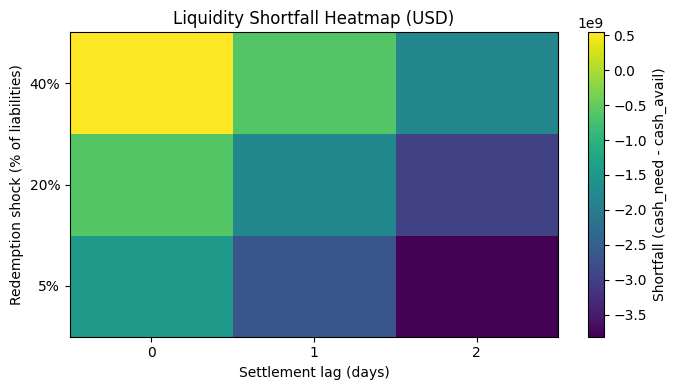

In [ ]:
import os
import matplotlib.pyplot as plt

# Pivot to a scenario grid: rows=redeem shock, cols=settlement lag, values=shortfall (USD)
pivot = (
    liq.pivot(index="redeem_pct", columns="settlement_days", values="shortfall")
    .sort_index()
    .sort_index(axis=1)
)

os.makedirs("figures", exist_ok=True)

# Plot heatmap of liquidity shortfall across scenarios
plt.figure(figsize=(7, 4))
im = plt.imshow(pivot.values, aspect="auto", origin="lower")

# Axis ticks/labels aligned with pivot ordering
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f"{x:.0%}" for x in pivot.index])

plt.xlabel("Settlement lag (days)")
plt.ylabel("Redemption shock (% of liabilities)")
plt.title("Liquidity Shortfall Heatmap (USD)")
plt.colorbar(im, label="Shortfall (cash_need - cash_avail)")

plt.tight_layout()

# Save
outpath = "figures/liquidity_shortfall_heatmap.png"
plt.savefig(outpath, dpi=200, bbox_inches="tight")
print("saved:", os.path.abspath(outpath))

plt.show()
plt.close()